In [1]:
import numpy as np
from numpy import random

from matplotlib import pyplot as plt
import math
from math import hypot

from itertools import cycle

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

import cv2

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [2]:
def Method_OpticalFlowDepthMap(image1_jpg, image2_jpg):
    vec_optical_flow = cv2.calcOpticalFlowFarneback(image1_jpg, image2_jpg, None, 0.5, 3, 20, 10, 5, 1.2, 0)
    module_vector_speed, angular_vec_speed = cv2.cartToPolar(vec_optical_flow[..., 0], vec_optical_flow[..., 1])
    return vec_optical_flow, module_vector_speed, angular_vec_speed

In [3]:
def plot(title_str, image, index):
    plt.subplot(2, 2, index)
    plt.title(title_str)
    plt.imshow(image, 'gray')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

In [4]:
def convert_ply(points):
    with open(r'F:\Diplom\BKP(mag)\Habr\points.ply', 'w') as f:
        f.write('ply\n')
        f.write('format ascii 1.0\n')
        f.write('element vertex {}\n'.format(len(points)))
        f.write('property float x\n')
        f.write('property float y\n')
        f.write('property float z\n')
        f.write('end_header\n')
        for point in points:
            f.write('{:.2f} {:.2f} {:.2f}\n'.format(point[0], point[2], point[1]))

In [5]:
B = 1
B_step = 1
w_width = 1920
h_heigth = 1080
f_focalLength = 250

Z = 31
delta = 1.4

image1_jpg = cv2.imread(r'F:\Diplom\BKP(mag)\Habr\1.jpg', 0)
image2_jpg = cv2.imread(r'F:\Diplom\BKP(mag)\Habr\2.jpg', 0)

def get_point_cloud_2D():
    vec_optical_flow = cv2.calcOpticalFlowFarneback(image1_jpg, image2_jpg, None, 0.5, 3, 20, 10, 5, 1.2, 0)
    module_vector_speed, angular_vec_speed = cv2.cartToPolar(vec_optical_flow[..., 0], vec_optical_flow[..., 1])

    conture = cv2.Canny(image1_jpg, 100, 200)
    
    point_cloud2D = []
    for y in range(image1_jpg.shape[0]):
        for x in range(image1_jpg.shape[1]):
            if conture[y, x] == 0:
                continue
            #delta = module_vector_speed[y, x]
            #if delta == 0:
                #continue
            Z_axes = (B * f_focalLength) / delta
            X_axes = (Z * (x - h_heigth / 2.)) / f_focalLength
            Y_axes = (Z * (y - h_heigth / 2.)) / f_focalLength
            tmp_point = np.array([X_axes, Y_axes, Z_axes])
            point_cloud2D.append(tmp_point)

    return point_cloud2D

def get_point_cloud_3D():
    vec_optical_flow = cv2.calcOpticalFlowFarneback(image1_jpg, image2_jpg, None, 0.5, 3, 20, 10, 5, 1.2, 0)
    module_vector_speed, angular_vec_speed = cv2.cartToPolar(vec_optical_flow[..., 0], vec_optical_flow[..., 1])

    conture = cv2.Canny(image1_jpg, 100, 200)

    point_cloud3D = []

    for y in range(image1_jpg.shape[0]):
        for x in range(image1_jpg.shape[1]):
            if conture[y, x] == 0:
                continue
            delta = angular_vec_speed[y, x]
            if delta == 0:
                continue
            Z_axes = (B * f_focalLength) / delta
            X_axes = (Z * (x - h_heigth / 2.)) / f_focalLength
            Y_axes = (Z * (y - h_heigth / 2.)) / f_focalLength
            tmp_point = np.array([X_axes, Y_axes, Z_axes])
            point_cloud3D.append(tmp_point)

    for y in range(image1_jpg.shape[0]):
        for x in range(image1_jpg.shape[1]):
            if conture[y, x] == 0:
                continue
            delta = module_vector_speed[y, x]
            if delta == 0:
                continue
            Z_axes = (B * f_focalLength) / delta
            X_axes = (Z * (x - h_heigth / 2.)) / f_focalLength
            Y_axes = (Z * (y - h_heigth / 2.)) / f_focalLength
            tmp_point = np.array([X_axes, Y_axes, Z_axes])
            point_cloud3D.append(tmp_point)

    for y in range(image1_jpg.shape[0]):
        for x in range(image1_jpg.shape[1]):
            if conture[y, x] == 0:
                continue
            #delta = module_vector_speed[y, x]
            #if delta == 0:
                #continue
            Z_axes = (B * f_focalLength) / delta
            X_axes = (Z * (x - h_heigth / 2.)) / f_focalLength
            Y_axes = (Z * (y - h_heigth / 2.)) / f_focalLength
            tmp_point = np.array([X_axes, Y_axes, Z_axes])
            point_cloud3D.append(tmp_point)

    point_cloud3D = np.vstack(point_cloud3D)
    return point_cloud3D

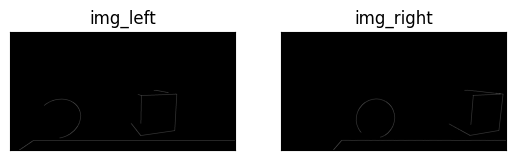

In [6]:
conture1 = cv2.Canny(image1_jpg, 100, 200)
conture2 = cv2.Canny(image2_jpg, 100, 200)

plot('img_left', conture1, 1)
plot('img_right', conture2, 2)

In [7]:
points_2d = get_point_cloud_2D()
points_3D = get_point_cloud_3D()

In [8]:
convert_ply(points_2d)
#convert_ply(points_3D)

In [43]:
filtered_points3D = []
for i in range(len(points_3D)):
    if(23 <= points_3D[i][2] <= 91):
        filtered_points3D.append(points_3D[i])

convert_ply(filtered_points3D)

# Кластерищация

In [10]:
def distance2D(point1, point2):
        return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
    
def find_neighbours(points_set, point1, eps):
    neighbours = []
    for point2 in points_set:
        if distance2D(point1, point2) < eps:
            neighbours.append(point2)
    return neighbours

def update_cluster(p, neighbours, clusters, clustered_points, visited_points, eps, m, points_set, NOISE, C):
    if C not in clusters:
        clusters[C] = []
    clusters[C].append(p)
    clustered_points.add(p)
    while neighbours:
        q = neighbours.pop()
        if q not in visited_points:
            visited_points.add(q)
            neighbourz = find_neighbours(points_set, q, eps)
            if len(neighbourz) > m:
                neighbours.extend(neighbourz)
        if q not in clustered_points:
            clustered_points.add(q)
            clusters[C].append(q)
            if q in clusters[NOISE]:
                clusters[NOISE].remove(q)

def dbscan_naive(points_set, eps, m, distance2D):
    NOISE = 0
    C = 1
    visited_points = set()
    clustered_points = set()
    clusters = {NOISE: []}

    for point1 in points_set:
        if point1 in visited_points:
            continue
        visited_points.add(point1)
        neighbours = find_neighbours(points_set, point1, eps)
        if len(neighbours) < m:
            clusters[NOISE].append(point1)
        else:
            C += 1
            update_cluster(point1, neighbours, clusters, clustered_points, visited_points, eps, m, points_set, NOISE, C)

    return clusters

# Пример

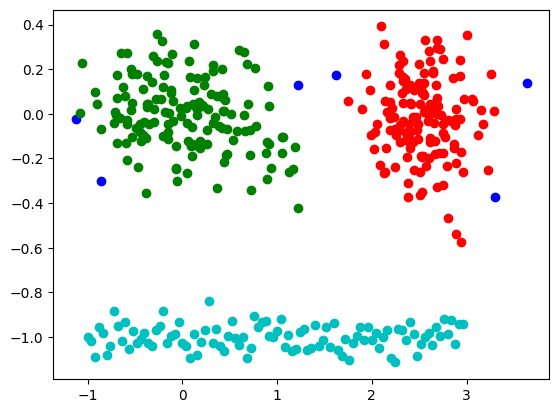

In [11]:
if __name__ == "__main__":
    P = [(random.randn()/2, random.randn()/6) for i in range(150)]
    P.extend([(random.randn()/3 + 2.5, random.randn()/5) for i in range(150)])
    P.extend([(i/25 - 1, + random.randn()/20 - 1) for i in range(100)])
    clusters = dbscan_naive(P, 0.2, 4, lambda x, y: hypot(x[0] - y[0], x[1] - y[1]))
    for c, points in zip(cycle('bgrcmykgrcmykgrcmykgrcmykgrcmykgrcmyk'), clusters.values()):
        X = [p[0] for p in points]
        Y = [p[1] for p in points]
        plt.scatter(X, Y, c=c)
    plt.show()

# Применение

In [12]:
def find_eps():
    random_eps_arr = np.random.randint(0, 101, size=1000)
    for epsilon in random_eps_arr: 
        dbscan = DBSCAN(eps = epsilon, min_samples = 20)
        dbscan.fit(points_2d)
        labels = dbscan.labels_
        unique_labels = np.unique(labels)
        if(len(unique_labels) == 4):
            return epsilon

In [13]:
dbscan = DBSCAN(eps = 8, min_samples = 20)
dbscan.fit(points_2d)

labels = dbscan.labels_

### eps: 

In [17]:
epsilon = find_eps()
epsilon

np.int32(2)

### обучение с таким eps

In [18]:
dbscan = DBSCAN(eps = epsilon, min_samples = 20)
dbscan.fit(points_2d)
labels = dbscan.labels_
unique_labels = np.unique(labels)

clusters = [[] for _ in range(0, len(unique_labels + 1))]

for i in range(len(labels)):
    label = labels[i]
    clusters[label - 1].append(points_2d[i])
    
for i in range(len(clusters)):
    clusters[i] = np.array(clusters[i])  

### число кластеров

In [19]:
len(clusters)

4

### рассмотрим кластер

In [20]:
def find_max_min_coord_2D(points):
    max_x = max(point[0] for point in points)
    min_x = min(point[0] for point in points)

    max_z = max(point[1] for point in points)
    min_z = min(point[1] for point in points)

    print(min_x, max_x)
    print(min_z, max_z)

    return min_x, max_x, min_z, max_z

def find_max_min_coord_3D(points):
    max_x = max(point[0] for point in points)
    min_x = min(point[0] for point in points)

    max_z = max(point[1] for point in points)
    min_z = min(point[1] for point in points)

    max_y = max(point[2] for point in points)
    min_y = min(point[2] for point in points)

    print(min_x, max_x)
    print(min_z, max_z)
    print(min_y, max_y)

    return min_x, max_x, min_z, max_z, min_y, max_y

In [21]:
def generate_cube(n, scale):
    points = []
    for i in range(6):  # 6 граней куба
        # Определение вершин грани
        face_vertices = [
            [0, 0, 0], [1 * scale, 0, 0], [1 * scale, 1 * scale, 0], [0, 1 * scale, 0]
        ] if i == 0 else [
            [1 * scale, 0, 0], [1 * scale, 0, 1 * scale], [1 * scale, 1 * scale, 1 * scale], [1 * scale, 1 * scale, 0]
        ] if i == 1 else [
            [1 * scale, 1 * scale, 0], [0, 1 * scale, 0], [0, 1 * scale, 1 * scale], [1 * scale, 1 * scale, 1 * scale]
        ] if i == 2 else [
            [0, 1 * scale, 0], [0, 0, 0], [0, 0, 1 * scale], [0, 1 * scale, 1 * scale]
        ] if i == 3 else [
            [0, 0, 0], [1 * scale, 0, 0], [1 * scale, 0, 1], [0, 0, 1 * scale]
        ] if i == 4 else [
            [0, 0, 1 * scale], [1 * scale , 0, 1 * scale], [1 * scale, 1 * scale, 1 * scale], [0, 1 * scale, 1 * scale]
        ]

        # Генерируем точки на грани
        for _ in range(n):  # n точек на каждой грани
            # Случайные координаты на грани
            x = np.random.uniform(0, 1)
            point = [
                face_vertices[0][0] + x * (face_vertices[1][0] - face_vertices[0][0]) + (face_vertices[3][0] - face_vertices[0][0]),
                face_vertices[0][1] + x * (face_vertices[1][1] - face_vertices[0][1]) + (face_vertices[3][1] - face_vertices[0][1]),
                face_vertices[0][2] + x * (face_vertices[1][2] - face_vertices[0][2]) + (face_vertices[3][2] - face_vertices[0][2])
            ]
            points.append(point)

        for _ in range(n):
            y = np.random.uniform(0, 1)
            point = [
                face_vertices[0][0] + (face_vertices[1][0] - face_vertices[0][0]) + y * (face_vertices[3][0] - face_vertices[0][0]),
                face_vertices[0][1] + (face_vertices[1][1] - face_vertices[0][1]) + y * (face_vertices[3][1] - face_vertices[0][1]),
                face_vertices[0][2] + (face_vertices[1][2] - face_vertices[0][2]) + y * (face_vertices[3][2] - face_vertices[0][2])
            ]
            points.append(point)

        # Генерируем точки на ребре
        for _ in range(n):  # n точек на каждом ребре
            # Случайные координаты на ребре
            x = np.random.uniform(0, 1)
            point = [
                face_vertices[0][0] + x * (face_vertices[1][0] - face_vertices[0][0]),
                face_vertices[0][1] + x * (face_vertices[1][1] - face_vertices[0][1]),
                face_vertices[0][2] + x * (face_vertices[1][2] - face_vertices[0][2])
            ]
            points.append(point)

    return points

In [22]:
def plot_cube_2d(points):

    eps = 0.02
    
    # y = 1 (B грань)
    points_with_y1 = [point for point in points if point[2] == 1]
    # y = 0 (F грань)
    points_with_y0 = [point for point in points if -eps < point[2]  < eps]
    x_B = [point[0] for point in points_with_y1]
    z_B = [point[1] for point in points_with_y1]
    x_F = [point[0] for point in points_with_y0]
    z_F = [point[1] for point in points_with_y0]

    # x = 1 (L грань)
    points_with_x1 = [point for point in points if 1 - eps <= point[0] <= 1 ]
    # x = 0 (R грань)
    points_with_x0 = [point for point in points if 0 - eps <= point[0] <= 0 + eps]
    y_L = [point[2] for point in points_with_x1]
    z_L = [point[1] for point in points_with_x1]
    y_R = [point[2] for point in points_with_x0]
    z_R = [point[1] for point in points_with_x0]

    # z = 1 (U грань)
    points_with_z1 = [point for point in points if 1 - eps <= point[1] <= 1 ]
    # z = 0 (D грань)
    points_with_z0 = [point for point in points if 0 - eps <= point[1] <= 0 + eps]
    x_U = [point[0] for point in points_with_z1]
    y_U = [point[2] for point in points_with_z1]
    x_D = [point[0] for point in points_with_z0]
    y_D = [point[2] for point in points_with_z0]

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    axes[0, 0].scatter(x_B, z_B, c='r', marker='o')
    axes[0, 0].set_xlabel('X')
    axes[0, 0].set_ylabel('Z')
    axes[0, 0].set_title('B')

    axes[0, 1].scatter(x_F, z_F, c='r', marker='o')
    axes[0, 1].set_xlabel('X')
    axes[0, 1].set_ylabel('Y')
    axes[0, 1].set_title('F')

    axes[0, 2].scatter(y_L, z_L, c='r', marker='o')
    axes[0, 2].set_xlabel('Y')
    axes[0, 2].set_ylabel('Z')
    axes[0, 2].set_title('L')

    axes[1, 0].scatter(y_R, z_R, c='r', marker='o')
    axes[1, 0].set_xlabel('X')
    axes[1, 0].set_ylabel('Z')
    axes[1, 0].set_title('R')

    axes[1, 1].scatter(x_U, y_U, c='r', marker='o')
    axes[1, 1].set_xlabel('X')
    axes[1, 1].set_ylabel('Y')
    axes[1, 1].set_title('U')

    axes[1, 2].scatter(x_D, y_D, c='r', marker='o')
    axes[1, 2].set_xlabel('Y')
    axes[1, 2].set_ylabel('Z')
    axes[1, 2].set_title('D')


In [23]:
def find_mean_2D(points):

    eps = 0.02
    
    # y = 1 (B грань)
    points_with_y1 = [point for point in points if point[2] == 1]
    # y = 0 (F грань)
    points_with_y0 = [point for point in points if -eps < point[2]  < eps]
    x_B = [point[0] for point in points_with_y1]
    z_B = [point[1] for point in points_with_y1]
    x_F = [point[0] for point in points_with_y0]
    z_F = [point[1] for point in points_with_y0]

    # x = 1 (L грань)
    points_with_x1 = [point for point in points if 1 - eps <= point[0] <= 1 ]
    # x = 0 (R грань)
    points_with_x0 = [point for point in points if 0 - eps <= point[0] <= 0 + eps]
    y_L = [point[2] for point in points_with_x1]
    z_L = [point[1] for point in points_with_x1]
    y_R = [point[2] for point in points_with_x0]
    z_R = [point[1] for point in points_with_x0]

    # z = 1 (U грань)
    points_with_z1 = [point for point in points if 1 - eps <= point[1] <= 1 ]
    # z = 0 (D грань)
    points_with_z0 = [point for point in points if 0 - eps <= point[1] <= 0 + eps]
    x_U = [point[0] for point in points_with_z1]
    y_U = [point[2] for point in points_with_z1]
    x_D = [point[0] for point in points_with_z0]
    y_D = [point[2] for point in points_with_z0]

    mean_x_B = sum(x_B) / len(x_B)
    mean_z_B = sum(z_B) / len(z_B)

    mean_x_F = sum(x_F) / len(x_F)
    mean_z_F = sum(z_F) / len(z_F)

    mean_y_L = sum(y_L) / len(y_L)
    mean_z_L = sum(z_L) / len(z_L)

    mean_y_R = sum(y_R) / len(y_R)
    mean_z_R = sum(z_R) / len(z_R)

    mean_x_U = sum(x_U) / len(x_U)
    mean_y_U = sum(y_U) / len(y_U)

    mean_x_D = sum(x_D) / len(x_D)
    mean_y_D = sum(y_D) / len(y_D)   

    eps = 0.25
    distances_B = [np.sqrt((x - mean_x_B) ** 2 + (z - mean_z_B) ** 2) for x, z in zip(x_B, z_B)]
    # Среднее расстояние
    mean_distance_B = np.mean(distances_B)
    filtered_points_B = [point for point, distance in zip(points_with_y1, distances_B) 
                   if abs(distance - mean_distance_B) <= eps]

    distances_F = [np.sqrt((x - mean_x_F) ** 2 + (z - mean_z_F) ** 2) for x, z in zip(x_F, z_F)]
    # Среднее расстояние
    mean_distance_F = np.mean(distances_F)
    filtered_points_F = [point for point, distance in zip(points_with_y0, distances_F) 
                   if abs(distance - mean_distance_F) <= eps]

    distances_L = [np.sqrt((y - mean_y_L) ** 2 + (z - mean_z_L) ** 2) for y, z in zip(y_L, z_L)]
    # Среднее расстояние
    mean_distance_L = np.mean(distances_L)
    filtered_points_L = [point for point, distance in zip(points_with_x1, distances_L) 
                   if abs(distance - mean_distance_L) <= eps]

    distances_R = [np.sqrt((y - mean_y_R) ** 2 + (z - mean_z_R) ** 2) for y, z in zip(y_R, z_R)]
    # Среднее расстояние
    mean_distance_R = np.mean(distances_R)
    filtered_points_R = [point for point, distance in zip(points_with_x0, distances_R) 
                   if abs(distance - mean_distance_R) <= eps]

    distances_U = [np.sqrt((x - mean_x_U) ** 2 + (y - mean_y_U) ** 2) for x, y in zip(x_U, y_U)]
    # Среднее расстояние
    mean_distance_U = np.mean(distances_U)
    filtered_points_U = [point for point, distance in zip(points_with_z1, distances_U) 
                   if abs(distance - mean_distance_U) <= eps]

    distances_D = [np.sqrt((x - mean_x_D) ** 2 + (y - mean_y_D) ** 2) for x, y in zip(x_D, y_D)]
    # Среднее расстояние
    mean_distance_D = np.mean(distances_D)
    filtered_points_D = [point for point, distance in zip(points_with_z0, distances_D) 
                   if abs(distance - mean_distance_D) <= eps]

    x_B, z_B, _ = zip(*filtered_points_B)
    x_F, z_F, _ = zip(*filtered_points_F)

    _, y_L, z_L = zip(*filtered_points_L)
    _, y_R, z_R = zip(*filtered_points_R)

    x_U, _, y_U = zip(*filtered_points_U)
    x_D, _, y_D = zip(*filtered_points_D)

    # Создаём фигуру с 6 подграфиками
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # График 1
    axs[0, 0].scatter(x_B, z_B, color='blue')
    axs[0, 0].set_title('График 1: filtered_points_B')
    axs[0, 0].set_xlabel('X')
    axs[0, 0].set_ylabel('Z')

    # График 2
    axs[0, 1].scatter(x_F, z_F, color='red')
    axs[0, 1].set_title('График 2: filtered_points_D')
    axs[0, 1].set_xlabel('X')
    axs[0, 1].set_ylabel('z')

    # График 3: Добавьте дополнительные графики в той же манере
    axs[0, 2].scatter(y_L, z_L, color='green')
    axs[0, 2].set_title('График 3: filtered_points_B (дубликат)')
    axs[0, 2].set_xlabel('y')
    axs[0, 2].set_ylabel('z')

    # График 4
    axs[1, 0].scatter(y_R, z_R, color='orange')
    axs[1, 0].set_title('График 4: filtered_points_D (дубликат)')
    axs[1, 0].set_xlabel('Y')
    axs[1, 0].set_ylabel('Z')

    # График 5
    axs[1, 1].scatter(x_U, y_U, color='purple', marker='o')
    axs[1, 1].set_title('График 5: Линия filtered_points_B')
    axs[1, 1].set_xlabel('X')
    axs[1, 1].set_ylabel('Y')

    # График 6
    axs[1, 2].scatter(x_D, y_D, color='brown', marker='x')
    axs[1, 2].set_title('График 6: Линия filtered_points_D')
    axs[1, 2].set_xlabel('X')
    axs[1, 2].set_ylabel('Y')

    # Автоматическое выравнивание подграфиков
    plt.tight_layout()
    plt.show()

    return mean_x_B, mean_z_B, mean_x_F, mean_z_F, mean_y_L, mean_z_L, mean_y_R, mean_z_R, mean_x_U, mean_y_U, mean_x_D, mean_y_D

In [24]:
def try_delete_rnd_points(points, n = 50):
    # Получаем текущие размеры массива
    shape = points.shape
    num_points = shape[0]  # Число точек в первом измерении

    # Проверяем, что n не больше количества точек
    if n > num_points:
        raise ValueError("n cannot be greater than the number of points in the array.")
    
    # Генерируем уникальные случайные индексы для удаления
    indices_to_remove = np.random.choice(num_points, n, replace=False)

    # Удаляем точки по выбранным индексам
    new_array = np.delete(points, indices_to_remove, axis=0)
    
    return new_array

In [47]:
# куб

len(clusters[0])

1174

In [48]:
min_x, max_x, min_z, max_z = find_max_min_coord_2D(clusters[0])

34.472 72.912
-17.36 20.46


In [57]:
# Объединить 3D точки к 2D кластеру

for i in range(len(filtered_points3D)):
    if(min_z <= filtered_points3D[i][1] <= max_z and min_x <= filtered_points3D[i][0] <= max_x):
        clusters[0] = np.concatenate([clusters[0], [filtered_points3D[i]]])

In [58]:
min_x, max_x, min_z, max_z, min_y, max_y = find_max_min_coord_3D(clusters[0])

34.472 72.912
-17.36 20.46
23.09519386291504 178.57142857142858


In [59]:
len(clusters[0])

5746

In [60]:
clusters[0]
convert_ply(clusters[0])

In [30]:
# Нормировка

points_normalized = np.zeros_like(clusters[1])
points_normalized[:, 0] = (clusters[0][:, 0] - min_x) / (max_x - min_x)
points_normalized[:, 2] = (clusters[0][:, 2] - min_y) / (max_y - min_y)
points_normalized[:, 1] = (clusters[0][:, 1] - min_z) / (max_z - min_z)

convert_ply(points_normalized)

ValueError: could not broadcast input array from shape (1174,) into shape (604,)

In [47]:
points_normalized

array([[0.44534413, 0.        , 1.        ],
       [0.4534413 , 0.        , 1.        ],
       [0.45748988, 0.        , 1.        ],
       ...,
       [0.43319838, 1.        , 0.02097098],
       [0.43724696, 1.        , 0.02097098],
       [0.44129555, 1.        , 0.02097098]])

In [26]:
# создать куб 1:1:1

points_cube = generate_cube(1000, 1)
# convert_ply(points_cube)

NameError: name 'generate_cube' is not defined

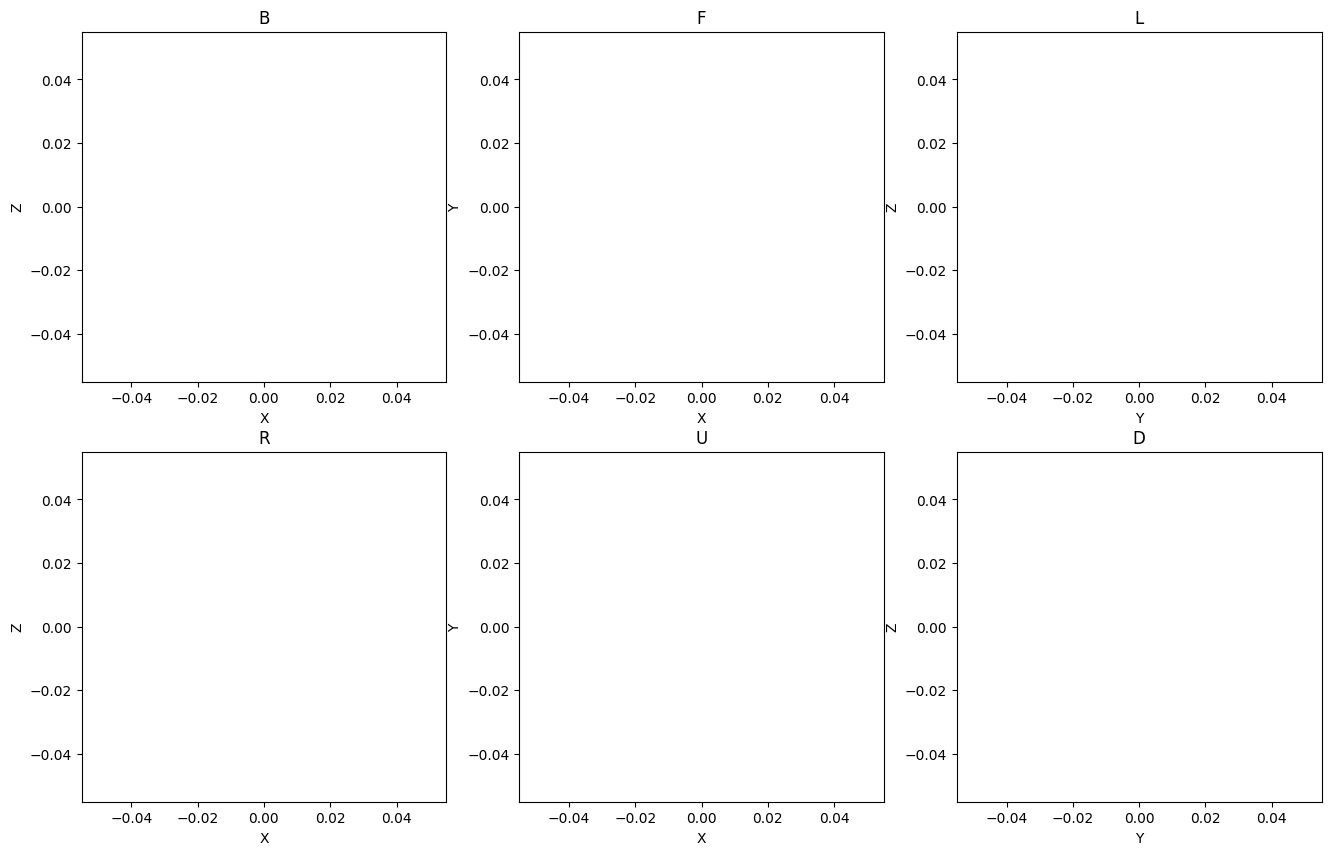

In [31]:
plot_cube_2d(points_normalized)

In [246]:
len(points_normalized)

2890

138

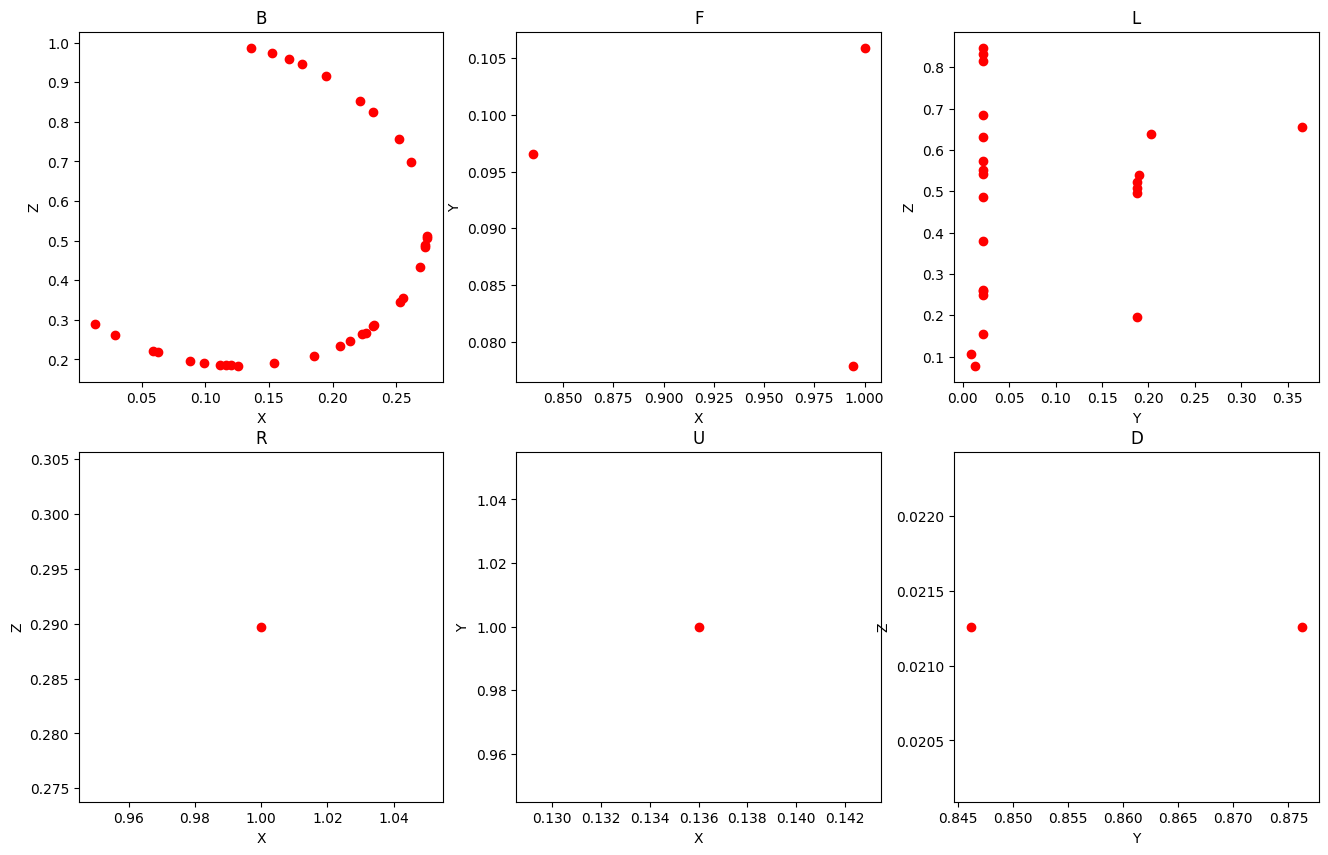

In [247]:
n = int(len(points_normalized) / 1.05)

# Генерируем случайные индексы для удаления
random_indices = np.random.choice(points_normalized.shape[0], n, replace=False)

# Удаляем точки по сгенерированным индексам
points_filtered = np.delete(points_normalized, random_indices, axis=0)

plot_cube_2d(points_filtered)
len(points_filtered)

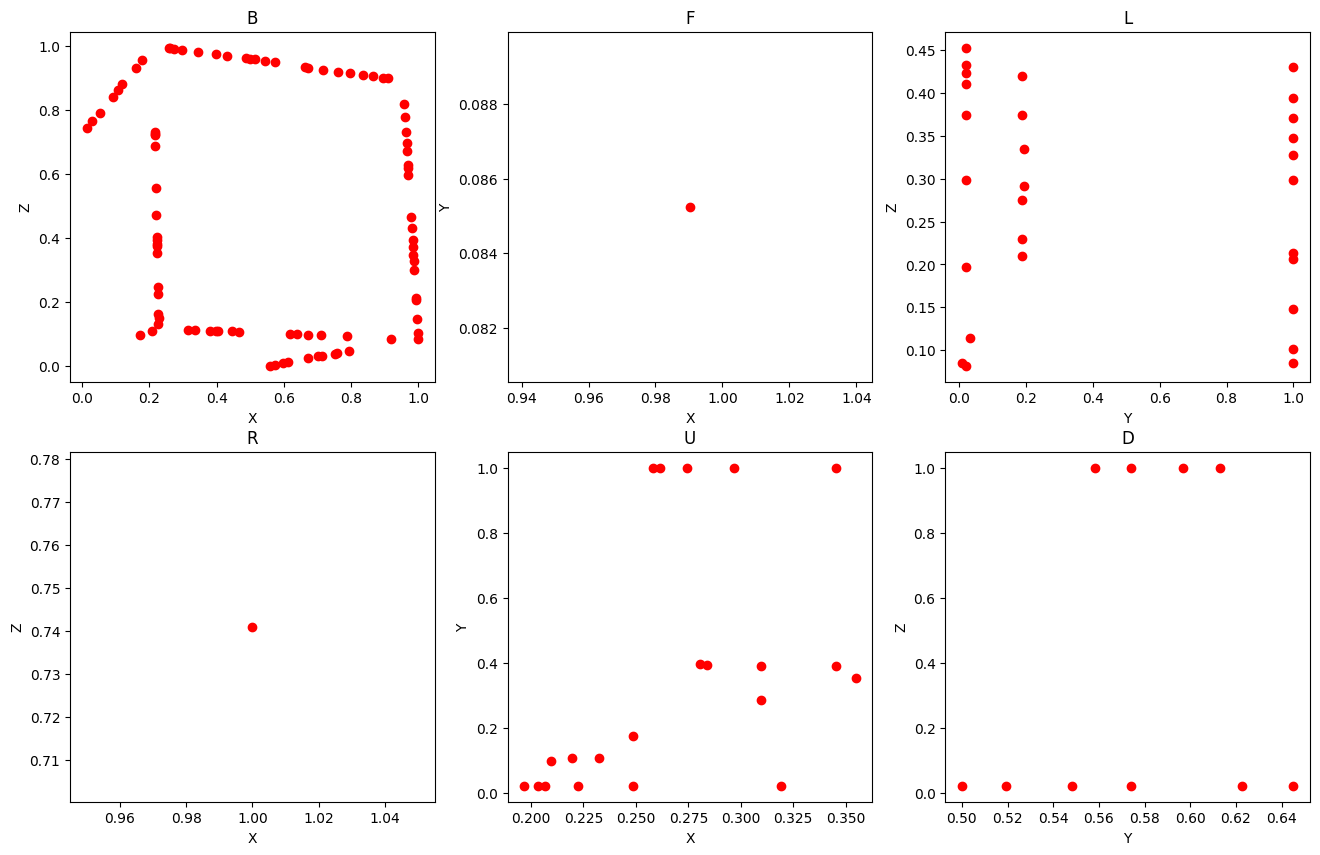

In [34]:
new_points = try_delete_rnd_points(points_normalized, 3200)
plot_cube_2d(new_points)

In [38]:
mean_x_B, mean_z_B, mean_x_F, mean_z_F, mean_y_L, mean_z_L, mean_y_R, mean_z_R, mean_x_U, mean_y_U, mean_x_D, mean_y_D = find_mean_2D(points_filtered)

print(mean_x_B, mean_z_B)

print(mean_x_F, mean_z_F)

print(mean_y_L, mean_z_L)

print(mean_y_R, mean_z_R)

print(mean_x_U, mean_y_U)

print(mean_x_D, mean_y_D)


ZeroDivisionError: division by zero

In [36]:
min_x, max_x, min_z, max_z = find_max_min_coord_2D(clusters[1])

-38.316 -7.688
-10.044 22.444


In [32]:
# Объединить 3D точки к 2D кластеру

for i in range(len(filtered_points3D)):
    if(min_z <= filtered_points3D[i][1] <= max_z and min_x <= filtered_points3D[i][0] <= max_x):
        clusters[0] = np.concatenate([clusters[0], [filtered_points3D[i]]])

In [33]:
# Нормировка

points_normalized_sphere = np.zeros_like(clusters[0])
points_normalized_sphere[:, 0] = (clusters[0][:, 0] - min_x) / (max_x - min_x)
points_normalized_sphere[:, 2] = (clusters[0][:, 2] - min_y) / (max_y - min_y)
points_normalized_sphere[:, 1] = (clusters[0][:, 1] - min_z) / (max_z - min_z)

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_8936\1748398483.py:5: RuntimeWarning: divide by zero encountered in divide
  points_normalized_sphere[:, 2] = (clusters[0][:, 2] - min_y) / (max_y - min_y)
C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_8936\1748398483.py:5: RuntimeWarning: invalid value encountered in divide
  points_normalized_sphere[:, 2] = (clusters[0][:, 2] - min_y) / (max_y - min_y)


In [34]:
convert_ply(points_normalized_sphere)

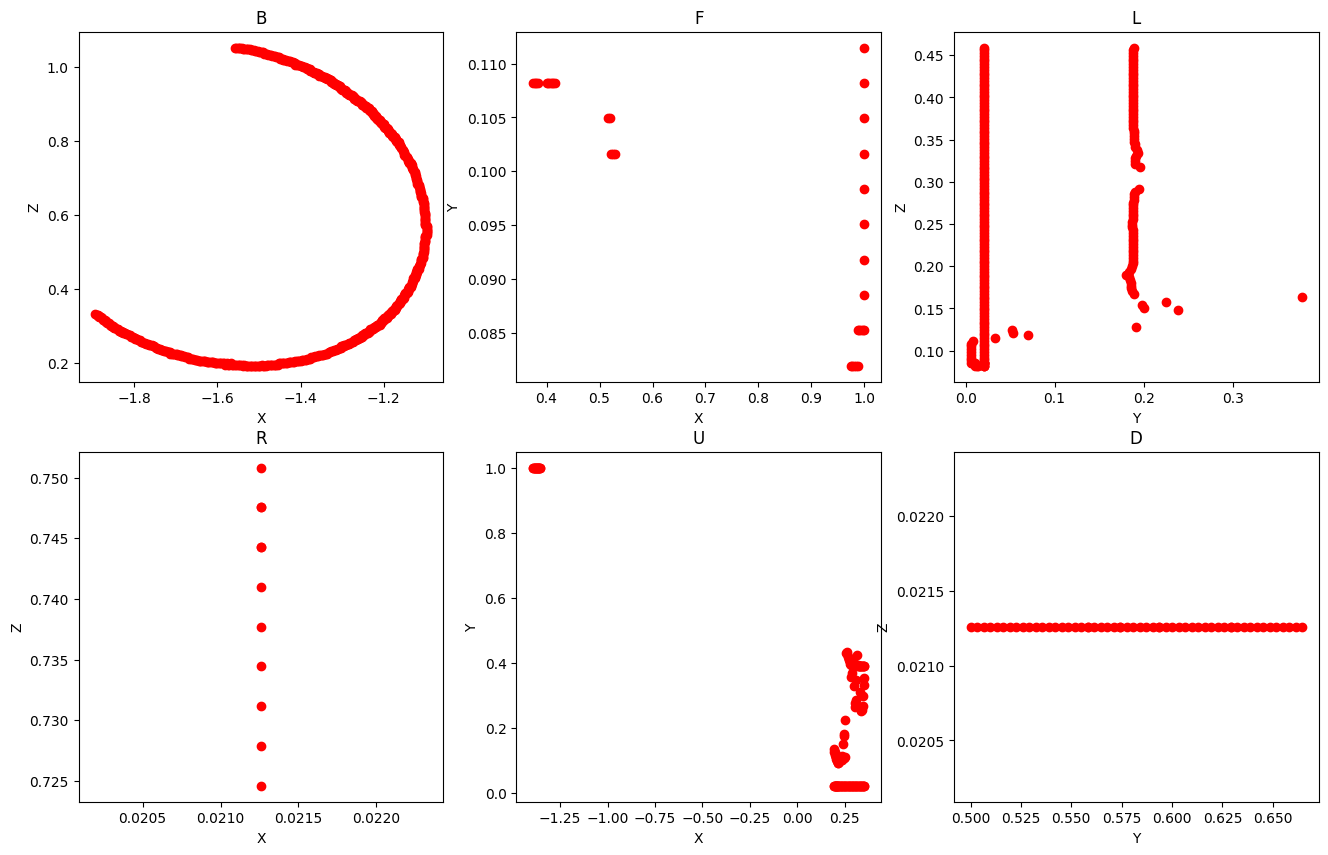

In [222]:
plot_cube_2d(points_normalized_sphere)

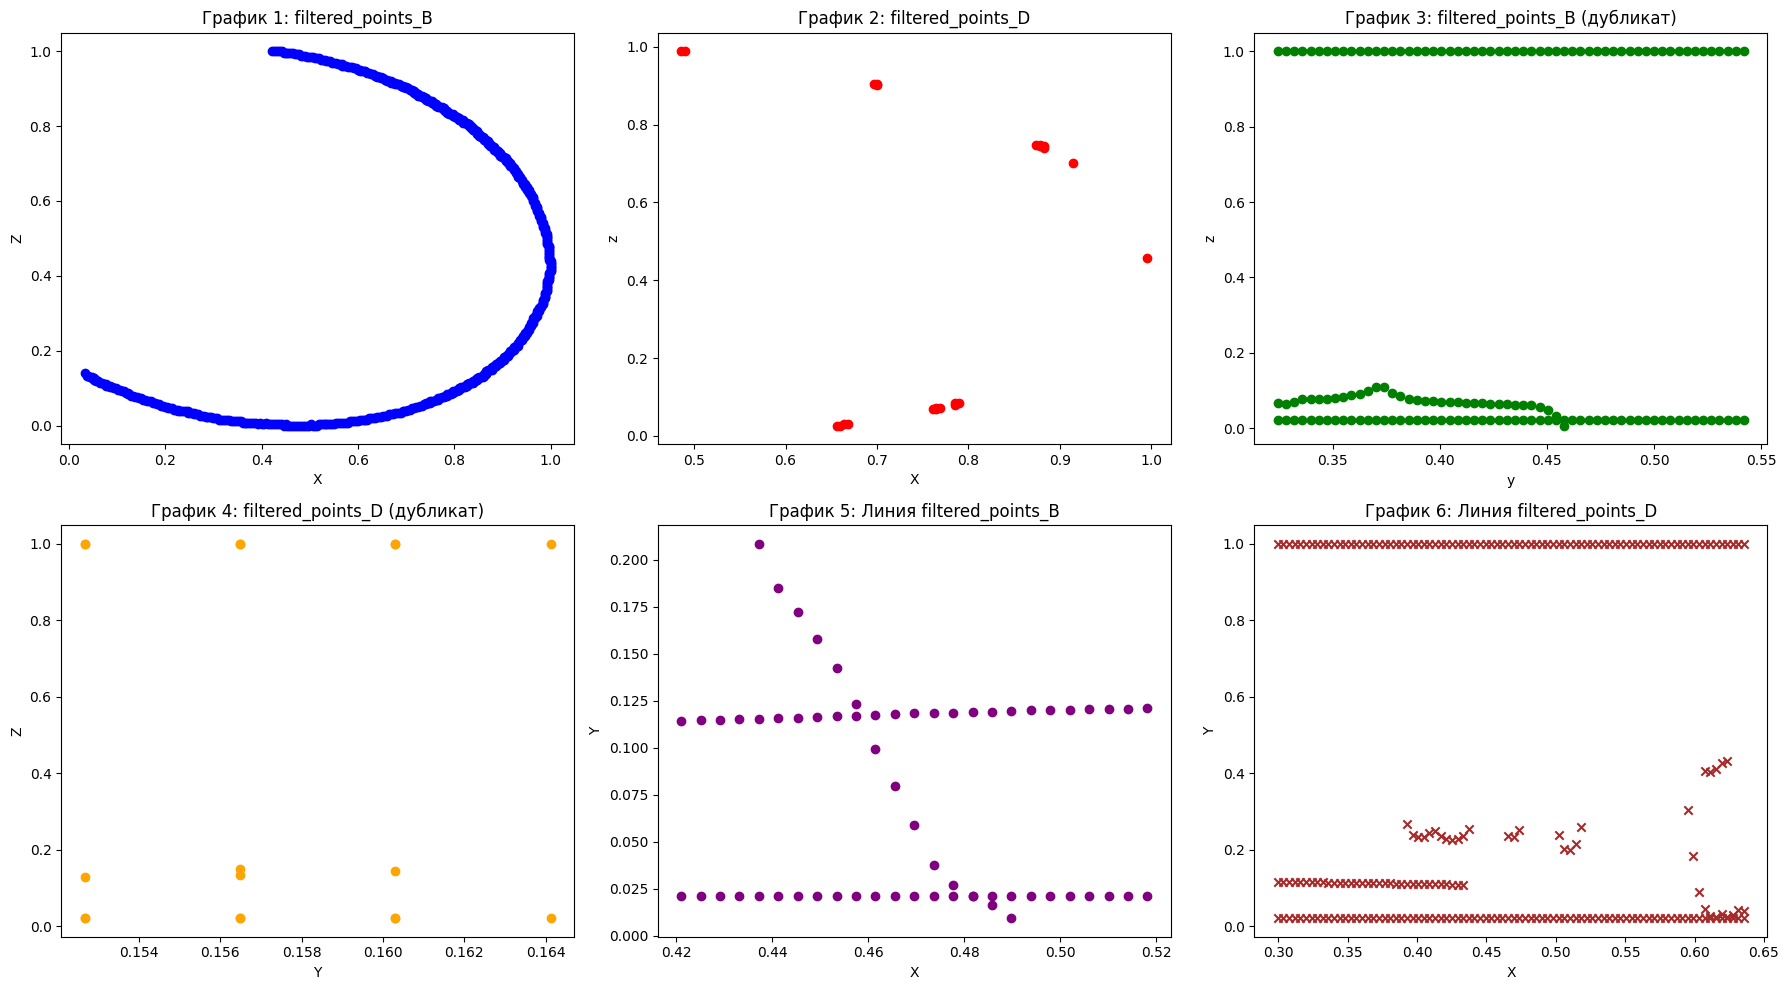

0.6726211223422794 0.40203983620646083
0.7586692483717655 0.44424161964819125
0.4000662350650716 0.4165256859913347
0.42808292598653197 0.15733672603901613
0.46689303904923596 0.3343953455225706
0.4608106263931221 0.40093409347484216


In [61]:
mean_x_B, mean_z_B, mean_x_F, mean_z_F, mean_y_L, mean_z_L, mean_y_R, mean_z_R, mean_x_U, mean_y_U, mean_x_D, mean_y_D = find_mean_2D(points_normalized_sphere)

print(mean_x_B, mean_z_B)

print(mean_x_F, mean_z_F)

print(mean_y_L, mean_z_L)

print(mean_y_R, mean_z_R)

print(mean_x_U, mean_y_U)

print(mean_x_D, mean_y_D)


# Классификация

In [122]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Distance:
    def __init__(self):
        self.distance = 0.0
        self.angle = 0.0
        self.index = 0
        self.position = 0.0

points_normalized

array([[0.44534413, 0.        ,        nan],
       [0.4534413 , 0.        ,        nan],
       [0.45748988, 0.        ,        nan],
       ...,
       [0.43319838, 1.        ,        nan],
       [0.43724696, 1.        ,        nan],
       [0.44129555, 1.        ,        nan]])

In [123]:
two_dim_array = points_normalized[:, :2] 

In [124]:
# Преобразование массива в формат source_points
source_points = [Point(x, y) for x, y in two_dim_array]

In [125]:
# Расчет центра фигуры
center_x = sum([point.x for point in source_points]) / len(source_points)
center_y = sum([point.y for point in source_points]) / len(source_points)

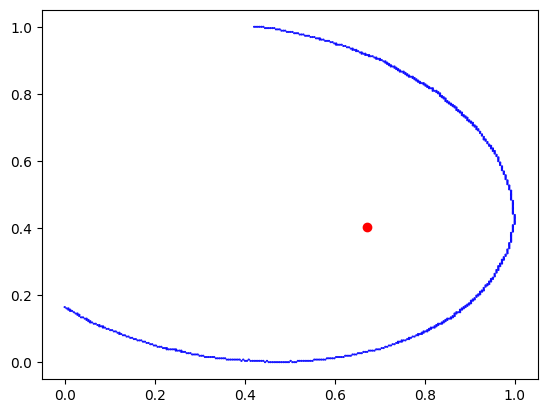

In [126]:
# Создаем фигуру и оси для графика
fig, ax = plt.subplots()

# Рисуем точки
for point in source_points:
  circle = Circle((point.x, point.y), radius=0.001, color='blue') # Создаем круг для точки
  ax.add_patch(circle) # Добавляем круг на график

# Рисуем центр
ax.plot(center_x, center_y, 'ro') # Рисуем красный кружок в центре

# Отображаем график
plt.show()

In [127]:
center_x, center_y

(np.float64(0.6726211223422794), np.float64(0.40203983620646083))

In [128]:
# Расчет расстояний от точек до центра
distancies = []
for index, point in enumerate(source_points):
    distance = Distance()
    delta_x = point.x - center_x
    delta_y = point.y - center_y
    distance.distance = delta_x ** 2 + delta_y ** 2
    distance.angle = np.arctan2(delta_x, delta_y)
    distance.index = index
    distancies.append(distance)

# Массив расстояний
distances_to_center = [d.distance for d in distancies]
indexes = [i.index for i in distancies]

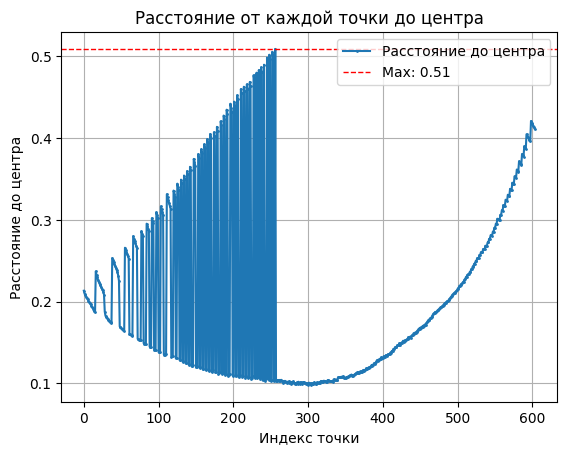

In [129]:
# Построение графика
plt.plot(indexes, distances_to_center, marker='o', markersize=1, label='Расстояние до центра')  # Уменьшите markersize
plt.title('Расстояние от каждой точки до центра')
plt.xlabel('Индекс точки')
plt.ylabel('Расстояние до центра')
plt.grid(True)


# Добавление линии для максимального расстояния
max_distance = max(distances_to_center)
plt.axhline(y=max_distance, color='r', linestyle='--', linewidth=1, label=f'Max: {max_distance:.2f}')

# Добавление легенды
plt.legend()

plt.show()

In [130]:
#min(distances_to_center)

count = 0
for i in range(len(distances_to_center)):
    if abs(distances_to_center[i] - max(distances_to_center)) < 0.01:
        count += 1
        #print(source_points[i].x, source_points[i].y)

In [131]:
distancies.sort(key=lambda d: d.angle)

# Нормализация расстояний, чтобы дальнейшие расчеты не зависели от размера фигуры.
minimal_angle = float('inf')
maximal_angle = float('-inf')
maximal_distance = float('-inf')

for distance in distancies:
    minimal_angle = min(distance.angle, minimal_angle)
    maximal_angle = max(distance.angle, maximal_angle)
    maximal_distance = max(distance.distance, maximal_distance)

for distance in distancies:
    distance.distance /= maximal_distance
    distance.position = len(source_points) * (distance.angle - minimal_angle) / (maximal_angle - minimal_angle)

In [132]:
# Определение функции бинарного поиска
def binary_search(distancies, target):
    low, high = 0, len(distancies) - 1
    while low <= high:
        mid = (low + high) // 2
        if distancies[mid].position < target.position:
            low = mid + 1
        elif distancies[mid].position > target.position:
            high = mid - 1
        else:
            return mid
    return -low - 1  # Возвращаем отрицательное значение, если не найдено

In [133]:
# Вычисление массива расстояний, в котором угол будет изменяться линейно относительно индекса в массиве.
for index in range(len(source_points)):
    dd = Distance()
    dd.position = index

    # Бинарный поиск
    found = binary_search(distancies, dd)

    if found >= 0:
        source_points[index] = distancies[found].distance
    else:
        point = -found - 1
        left = distancies[point - 1]
        right = distancies[point]
        factor = (index - left.position) / (left.position - right.position)

        source_points[index] = left.distance + factor * (left.distance - right.distance)

        if factor < 0.5:
            indexes[index] = point - 1
        else:
            indexes[index] = point

In [134]:
#Получаем массивы углов и расстояний
angles = [d.angle for d in distancies]
distances_to_center = [d.distance for d in distancies]

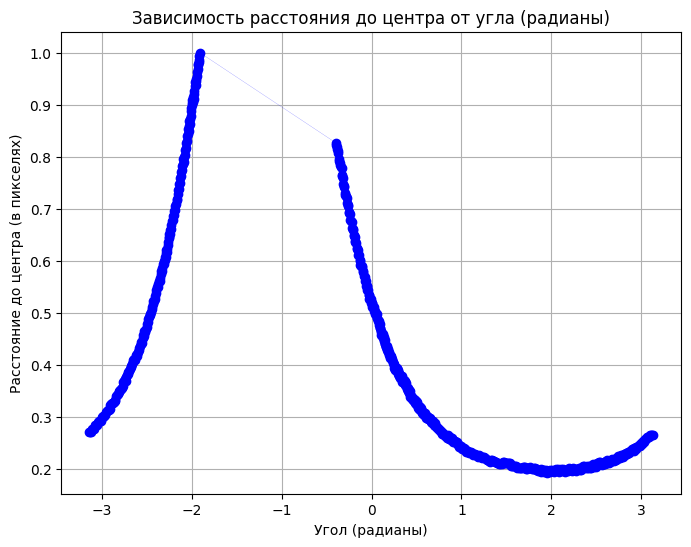

In [135]:
# Построение графика зависимости расстояния от угла
plt.figure(figsize=(8, 6))
plt.plot(angles, distances_to_center, marker='o', linestyle='-', color='b', linewidth=0.1) # Уменьшаем толщину линии
plt.title('Зависимость расстояния до центра от угла (радианы)')
plt.xlabel('Угол (радианы)')
plt.ylabel('Расстояние до центра (в пикселях)')
plt.grid(True)
plt.show()

In [136]:
# Функция для обнаружения пиков
def peak_detect(data_size):
    size = data_size // (2 * 5 + 1)
    center = (size // 2) | 1
    values = np.zeros(size)
    kernel_sum = 0.0

    for index in range(size):
        factor = abs(index - center) / (center + 1.0)
        values[index] = np.sqrt((1 - factor) ** 2 + 1) - 1
        kernel_sum += values[index]

    values -= kernel_sum / size

    return Kernel(values, center)

In [137]:
class Kernel:
    def __init__(self, values, center):
        self.values = values
        self.center = center

In [138]:
def create_kernel(size):
    kernel_values = np.zeros(size)
    kernel_sum = 0.0
    center = size // 2

    for index in range(size):
        factor = abs(index - center) / (center + 1.0)
        kernel_values[index] = np.sqrt((1 - factor) ** 2 + 1) - 1
        kernel_sum += kernel_values[index]

    # Нормируем ядро
    kernel_values += -kernel_sum / size
    return Kernel(kernel_values, center)

In [139]:
# Применение свертки
def apply_kernel(data, kernel):
    result = np.zeros(len(data))
    for data_index in range(len(data)):
        sum_value = 0.0
        for kernel_index in range(len(kernel.values)):
            offset = data_index + kernel_index - kernel.center
            if offset < 0:
                offset += len(data)
            if offset >= len(data):
                offset -= len(data)
            sum_value += kernel.values[kernel_index] * data[offset]
        result[data_index] = sum_value
    return result

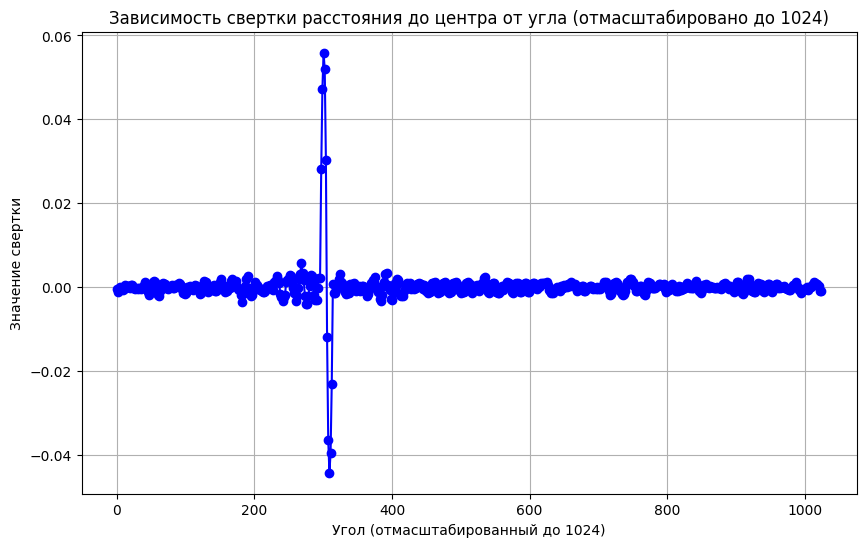

In [140]:
# Создаем ядро для свертки
kernel_size = 11  # Размер ядра
kernel = create_kernel(kernel_size)

# Применяем свертку к нормализованным расстояниям
convolved_values = apply_kernel([d.distance for d in distancies], kernel)

# Масштабируем углы для графика
scaled_angles = np.linspace(0, 1024, num=len(convolved_values))

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(scaled_angles, convolved_values, marker='o', linestyle='-', color='b')
plt.title('Зависимость свертки расстояния до центра от угла (отмасштабировано до 1024)')
plt.xlabel('Угол (отмасштабированный до 1024)')
plt.ylabel('Значение свертки')
plt.grid(True)
plt.show()

In [51]:
import random

#### Получение массива точек

In [100]:
# Преобразование массива в формат source_points
two_dim_array = points_normalized[:, :2] 
source_points = [Point(x, y) for x, y in two_dim_array]

len(source_points)

604

#### Удалим процент точек

In [101]:
# Доля точек, которые нужно оставить (40%)
fraction_to_keep = 0.05

# Вычисляем количество точек для сохранения
num_points_to_keep = int(len(source_points) * fraction_to_keep)

# Выбираем случайные точки, чтобы сохранить их
source_points = random.sample(source_points, num_points_to_keep)

In [102]:
len(source_points)

30

#### Построим

In [103]:
# Расчет центра фигуры
center_x = sum([point.x for point in source_points]) / len(source_points)
center_y = sum([point.y for point in source_points]) / len(source_points)
center_x, center_y

(np.float64(0.6040485829959512), np.float64(0.384351145038168))

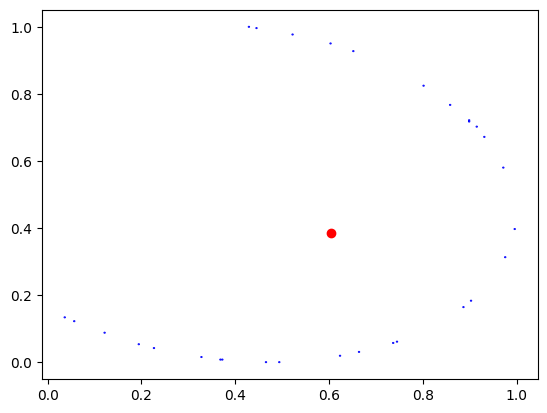

In [104]:
# Создаем фигуру и оси для графика
fig, ax = plt.subplots()

# Рисуем точки
for point in source_points:
  circle = Circle((point.x, point.y), radius = 0.001, color='blue') # Создаем круг для точки
  ax.add_patch(circle) # Добавляем круг на график

# Рисуем центр
ax.plot(center_x, center_y, 'ro') # Рисуем красный кружок в центре

# Отображаем график
plt.show()

#### Удалим близкие точки

In [105]:
def distance(point1, point2):
    return math.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)
    
# Значение epsilon
eps = 1e-6

# Создаем новый список для точек, которые пройдут проверку
filtered_points = []

for i, point in enumerate(source_points):
    # Проверяем расстояние до каждой другой точки
    has_close_neighbor = False
    for j, other_point in enumerate(source_points):
        if i != j and distance(point, other_point) < eps:
            has_close_neighbor = True
            break
    
    # Если близкого соседа нет, добавляем точку в отфильтрованный список
    if not has_close_neighbor:
        filtered_points.append(point)

# Перезаписываем source_points, чтобы оставить только отфильтрованные точки
source_points = filtered_points

#### Построим

In [106]:
# Расчет центра фигуры
center_x = sum([point.x for point in source_points]) / len(source_points)
center_y = sum([point.y for point in source_points]) / len(source_points)
center_x, center_y

(np.float64(0.6040485829959512), np.float64(0.384351145038168))

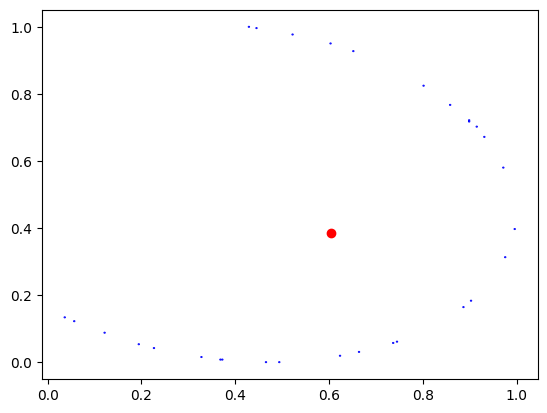

In [107]:
# Создаем фигуру и оси для графика
fig, ax = plt.subplots()

# Рисуем точки
for point in source_points:
  circle = Circle((point.x, point.y), radius=0.001, color='blue') # Создаем круг для точки
  ax.add_patch(circle) # Добавляем круг на график

# Рисуем центр
ax.plot(center_x, center_y, 'ro') # Рисуем красный кружок в центре

# Отображаем график
plt.show()

In [108]:
len(source_points)

30

#### Удалим точки по ср расстоянию

In [109]:
# Расчет центра фигуры
center_x = sum([point.x for point in source_points]) / len(source_points)
center_y = sum([point.y for point in source_points]) / len(source_points)
center_x, center_y

(np.float64(0.6040485829959512), np.float64(0.384351145038168))

In [110]:
# Расчет расстояний от точек до центра
distancies = []
for index, point in enumerate(source_points):
    distance = Distance()
    delta_x = point.x - center_x
    delta_y = point.y - center_y
    distance.distance = delta_x ** 2 + delta_y ** 2
    distance.angle = np.arctan2(delta_x, delta_y)
    distance.index = index
    distancies.append(distance)

# Массив расстояний
distances_to_center = [d.distance for d in distancies]
indexes = [i.index for i in distancies]

In [111]:
# Вычисление среднего расстояния до центра
mean_distance = np.mean(distances_to_center)
print (mean_distance)

# Задайте значение eps
eps = 0.2

# Удаление точек, у которых расстояние отличается от среднего более чем на eps
source_points = [
    source_points[dist.index] for dist in distancies 
    if abs(dist.distance - mean_distance) <= eps
]

# Количество оставшихся точек
len(source_points)

0.22660014645911716


30

#### Построим

In [112]:
# Расчет центра фигуры
center_x = sum([point.x for point in source_points]) / len(source_points)
center_y = sum([point.y for point in source_points]) / len(source_points)
center_x, center_y

(np.float64(0.6040485829959512), np.float64(0.384351145038168))

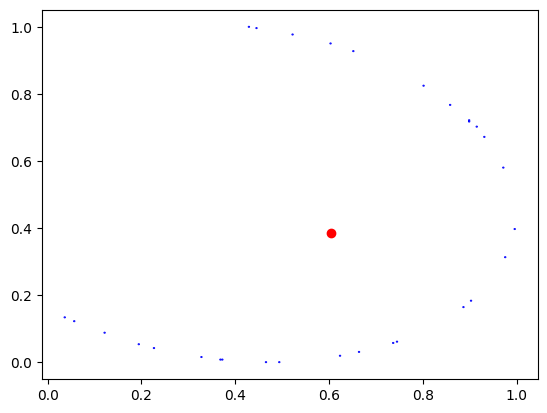

In [113]:
# Создаем фигуру и оси для графика
fig, ax = plt.subplots()

# Рисуем точки
for point in source_points:
  circle = Circle((point.x, point.y), radius=0.001, color='blue') # Создаем круг для точки
  ax.add_patch(circle) # Добавляем круг на график

# Рисуем центр
ax.plot(center_x, center_y, 'ro') # Рисуем красный кружок в центре

# Отображаем график
plt.show()

#### Графики

In [114]:
# Расчет расстояний от точек до центра
distancies = []
for index, point in enumerate(source_points):
    distance = Distance()
    delta_x = point.x - center_x
    delta_y = point.y - center_y
    distance.distance = delta_x ** 2 + delta_y ** 2
    distance.angle = np.arctan2(delta_x, delta_y)
    distance.index = index
    distancies.append(distance)

# Массив расстояний
distances_to_center = [d.distance for d in distancies]
indexes = [i.index for i in distancies]

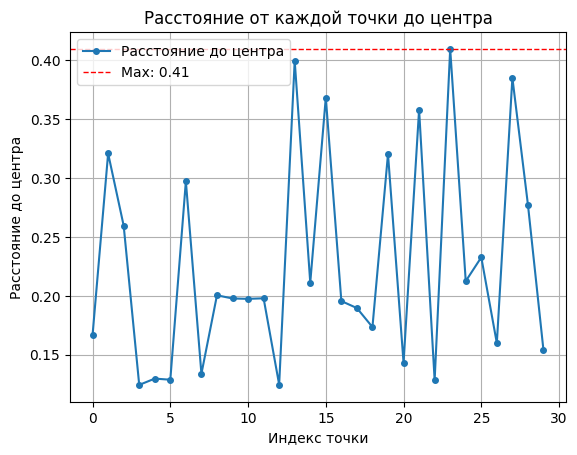

In [115]:
# Построение графика
plt.plot(indexes, distances_to_center, marker='o', markersize=4, label='Расстояние до центра')  # Уменьшите markersize
plt.title('Расстояние от каждой точки до центра')
plt.xlabel('Индекс точки')
plt.ylabel('Расстояние до центра')
plt.grid(True)


# Добавление линии для максимального расстояния
max_distance = max(distances_to_center)
plt.axhline(y=max_distance, color='r', linestyle='--', linewidth=1, label=f'Max: {max_distance:.2f}')

# Добавление легенды
plt.legend()

plt.show()

In [116]:
len(distancies)

30

In [117]:
distancies.sort(key=lambda d: d.angle)

# Нормализация расстояний, чтобы дальнейшие расчеты не зависели от размера фигуры.
minimal_angle = float('inf')
maximal_angle = float('-inf')
maximal_distance = float('-inf')

for distance in distancies:
    minimal_angle = min(distance.angle, minimal_angle)
    maximal_angle = max(distance.angle, maximal_angle)
    maximal_distance = max(distance.distance, maximal_distance)

for distance in distancies:
    distance.distance /= maximal_distance
    distance.position = len(source_points) * (distance.angle - minimal_angle) / (maximal_angle - minimal_angle)

In [118]:
# Вычисление массива расстояний, в котором угол будет изменяться линейно относительно индекса в массиве.
for index in range(len(source_points)):
    dd = Distance()
    dd.position = index

    # Бинарный поиск
    found = binary_search(distancies, dd)

    if found >= 0:
        source_points[index] = distancies[found].distance
    else:
        point = -found - 1
        left = distancies[point - 1]
        right = distancies[point]
        factor = (index - left.position) / (left.position - right.position)

        source_points[index] = left.distance + factor * (left.distance - right.distance)

        if factor < 0.5:
            indexes[index] = point - 1
        else:
            indexes[index] = point

In [119]:
#Получаем массивы углов и расстояний
angles = [d.angle for d in distancies]
distances_to_center = [d.distance for d in distancies]

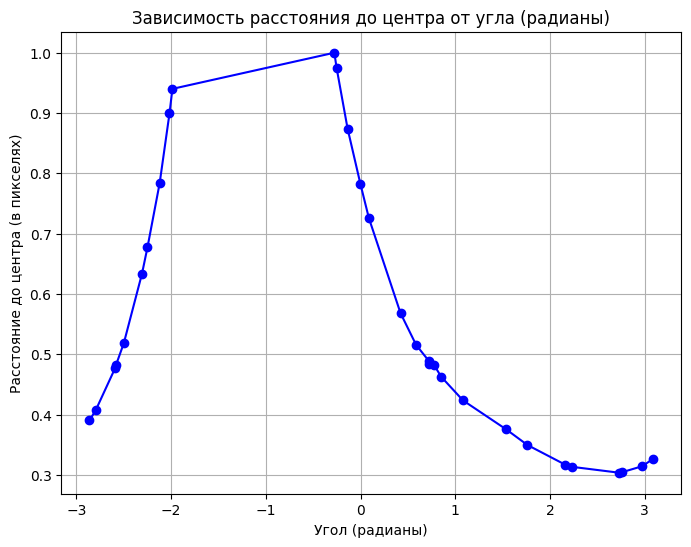

In [120]:
# Построение графика зависимости расстояния от угла
plt.figure(figsize=(8, 6))
plt.plot(angles, distances_to_center, marker='o', linestyle='-', color='b')
plt.title('Зависимость расстояния до центра от угла (радианы)')
plt.xlabel('Угол (радианы)')
plt.ylabel('Расстояние до центра (в пикселях)')
plt.grid(True)
plt.show()

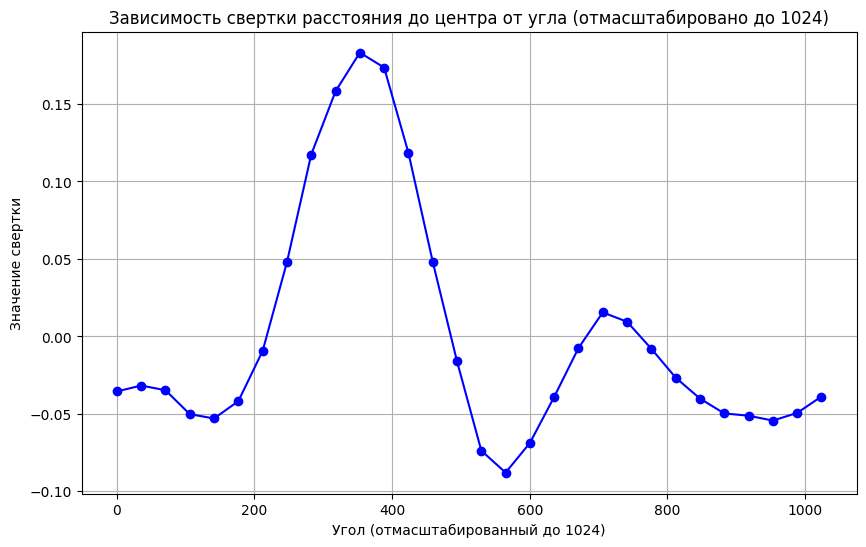

In [121]:
# Создаем ядро для свертки
kernel_size = 11  # Размер ядра
kernel = create_kernel(kernel_size)

# Применяем свертку к нормализованным расстояниям
convolved_values = apply_kernel([d.distance for d in distancies], kernel)

# Масштабируем углы для графика
scaled_angles = np.linspace(0, 1024, num=len(convolved_values))

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(scaled_angles, convolved_values, marker='o', linestyle='-', color='b')
plt.title('Зависимость свертки расстояния до центра от угла (отмасштабировано до 1024)')
plt.xlabel('Угол (отмасштабированный до 1024)')
plt.ylabel('Значение свертки')
plt.grid(True)
plt.show()